## Neural Network with Human Resource Analytics

In this notebook we will explore analyzing a Human Resource analytics data set and create a neural network to predict whether an employee will leave or stay based on certain features we are given. We will be using the Tensorflow, numpy and pandas python libraries to achieve this goal. The original data set can be found [here](https://www.kaggle.com/ludobenistant/hr-analytics). The original python script is setup to accept command line flags to try different techniques I worked through this data with. If you are interested in seeing the results of full batch versus mini-batch training or Recitified Linear Unit(Relu) versus Exponential Linear Unit(Elu) activation functions then you can try it [BROKEN LINK]().

In [1]:
## Using magic commands for set up and showing working versions
%matplotlib inline
%load_ext version_information
%version_information tensorflow, numpy, pandas, matplotlib

Software versions
Python 3.5.2 64bit [GCC 5.4.0 20160609]
IPython 5.1.0
OS Linux 4.4.0 62 generic x86_64 with Ubuntu 16.04 xenial
tensorflow 0.12.1
numpy 1.12.0
pandas 0.19.2
matplotlib 1.5.3
Wed Feb 15 20:44:46 2017 CST

In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np

Lets set our seeds for the environment and pull in our data.

In [3]:
np.random.seed(7)
tf.set_random_seed(7)

init_data = pd.read_csv("./HR_comma_sep.csv")

Now lets take a look at the data we are given.

In [4]:
print(init_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 10 columns):
satisfaction_level       14999 non-null float64
last_evaluation          14999 non-null float64
number_project           14999 non-null int64
average_montly_hours     14999 non-null int64
time_spend_company       14999 non-null int64
Work_accident            14999 non-null int64
left                     14999 non-null int64
promotion_last_5years    14999 non-null int64
sales                    14999 non-null object
salary                   14999 non-null object
dtypes: float64(2), int64(6), object(2)
memory usage: 1.1+ MB
None


As we can see we have 10 columns of features, 2 of those are of type object, with no null values in the data. Next we need to look at what type of data is in the two columns with the type object.

In [5]:
print("Sales: {0}".format(init_data["sales"][:5]))
print("Salary: {0}".format(init_data["salary"][:5]))

Sales: 0    sales
1    sales
2    sales
3    sales
4    sales
Name: sales, dtype: object
Salary: 0       low
1    medium
2    medium
3       low
4       low
Name: salary, dtype: object


At first glance it looks like the column "sales" is holding nominal data and the column "salary" is holding ordinal data. Lets see how many unique values we have in each column.

In [6]:
sales_unique_n = init_data["sales"].nunique()
salary_unique_n = init_data["salary"].nunique()
print("Unique sale categories: {0}".format(sales_unique_n))
print("Unique salary categories: {0}".format(salary_unique_n))

Unique sale categories: 10
Unique salary categories: 3


So the nominal data has 10 categories and the ordinal data has 3 categories. Now we need to convert this data into something that our nerual network can work with. The way we are going to handle converting this data is by breaking these categories down into their own binary features.

In [7]:
sales_unique_feature_names = init_data["sales"].unique()
salary_unique_feature_names = init_data["salary"].unique()

# Function to breakdown a category into individual binary features
def break_down_features(feature_list, category, orig_data):
    for name in feature_list:
        orig_data[category+"_"+name] = [1 if x == name else 0 for _, x in enumerate(orig_data[category])]

break_down_features(sales_unique_feature_names, "sales", init_data)
break_down_features(salary_unique_feature_names, "salary", init_data)

Now that we have broken down the categories lets get rid of our original sales and salary columns.

In [8]:
init_data = init_data.drop(["sales", "salary"], axis=1)

Since the feature we are wanting to predict is whether the employee has left or not, we should look at the percentages of left versus stayed in our data set.

In [9]:
print(init_data["left"].value_counts() / len(init_data["left"]))

0    0.761917
1    0.238083
Name: left, dtype: float64


So we have about ~76% of people who stayed and ~24% of people who left. When we split our data into the training and test sets we want to try and maintain these percentages in our new distributions. Lets create a function that will do this for us.

In [10]:
def stratified_split_data(data, ratio):
    # Grab the data into its own category
    stayed_data = data.loc[data["left"] == 0]
    left_data = data.loc[data["left"] == 1]
    # mix up the data
    stayed_data = stayed_data.iloc[np.random.permutation(len(stayed_data))]
    left_data = left_data.iloc[np.random.permutation(len(left_data))]
    test_stayed_set_size = int(len(stayed_data) * ratio)
    test_left_set_size = int(len(left_data) * ratio)
    # Concatenate the partitioned data
    train_set = pd.concat([stayed_data[test_stayed_set_size:], left_data[test_left_set_size:]], ignore_index=True)
    test_set = pd.concat([stayed_data[:test_stayed_set_size], left_data[:test_left_set_size]], ignore_index=True)
    # Now mix up the concatenated data
    train_shuffled_indices = np.random.permutation(len(train_set))
    test_shuffled_indices = np.random.permutation(len(test_set))
    return train_set.iloc[train_shuffled_indices], test_set.iloc[test_shuffled_indices]

train_set, test_set = stratified_split_data(init_data, 0.2)

Now we have our stratified samples. However, just to make sure, we can look at our training set percentages.

In [11]:
print(train_set["left"].value_counts() / len(train_set["left"]))

0    0.761917
1    0.238083
Name: left, dtype: float64


It seems our sample size's percentages match perfectly. So now lets split out our training set into the data and the data labels. Also lets grab the number of features we are working with.

In [12]:
data = (train_set.drop("left", axis=1)).values
data_labels = train_set["left"].values
data_labels = data_labels.reshape([len(data_labels), 1])
num_features = data.shape[1]

Now lets start defining our model. The model we will create will have 2 hidden layers and an output layer. Lets start with defining the inputs and labels.

In [13]:
X_init = tf.placeholder(tf.float32, [None, num_features])
Y_init = tf.placeholder(tf.float32, [None, 1])

Now lets create our first hidden layer. Typically your hidden layers will use a Rectified Linear Unit(Relu) activation function in these cases, but in our case we will use an Exponential Linear Unit(Elu) activation function for its nice properties of reducing the bias shift effect on our network to have faster learning than Relu and for the fact that it acts like batch normalization without the computational complexity. We will also add the caveat of initalizing our weights and biases with a standard deviation of 0.01.

In [14]:
w_1 = tf.Variable(tf.truncated_normal([num_features, 10], stddev=0.01))
b_1 = tf.Variable(tf.truncated_normal([10], stddev=0.01))

layer_1 = tf.nn.elu(tf.add(tf.matmul(X_init, w_1), b_1))

Our second hidden layer will be the same but adjusted for the new input shape.

In [15]:
w_2 = tf.Variable(tf.truncated_normal([10, 8], stddev=0.01))
b_2 = tf.Variable(tf.truncated_normal([8], stddev=0.01))

layer_2 = tf.nn.elu(tf.add(tf.matmul(layer_1, w_2), b_2))

And for our final output layer we will use the sigmoid function for our activation function because we want our output to be between 0 and 1.

In [16]:
w_3 = tf.Variable(tf.truncated_normal([8, 1], stddev=0.01))
b_3 = tf.Variable(tf.truncated_normal([1], stddev=0.01))

output_layer = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, w_3), b_3))

Next we will define our cost function, which will be the cross entropy loss function.

In [17]:
cost = -tf.reduce_mean(tf.multiply(Y_init, tf.log(output_layer)) + (1 - Y_init)*tf.log(1 - output_layer) )

For our optimizer we will use Adam with a learning rate of 1e-3.

In [18]:
optimizer = tf.train.AdamOptimizer(1e-3).minimize(cost)

Lets do some tensorflow setup and define an array to store our loss function values when we train our model.

In [19]:
init = tf.global_variables_initializer()

sess = tf.Session()

sess.run(init)

loss_values = []

I have played around with the values and have found decent numbers to use for our epoch and batch size in our model. We will use 600 epochs and a batch size of 50.

In [20]:
num_epochs = 600
batch_size = 50
count = len(data) # helper variable for our mini-batch training

Now lets set up our training and then print out our final cost value.

In [21]:
for epoch in range(num_epochs):
    start_n = 0
    c = None
    while start_n < count:
        sess.run(optimizer, feed_dict={X_init:data[start_n:(start_n + batch_size)], Y_init:data_labels[start_n:(start_n + batch_size)]})
        start_n += batch_size
    c = sess.run(cost, feed_dict={X_init:data, Y_init:data_labels})
    loss_values.append(c)
print("Final cost = {0}".format(sess.run(cost, feed_dict={X_init:data, Y_init:data_labels})) )

Final cost = 0.10991400480270386


Here is what the loss function looks like graphically.

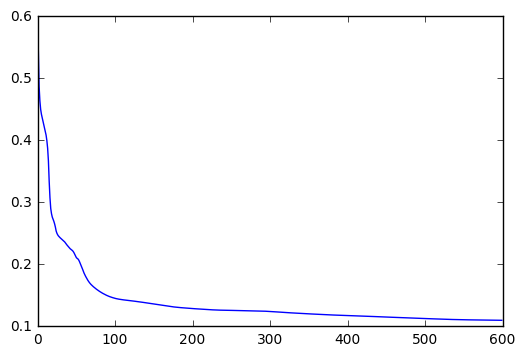

In [22]:
import matplotlib.pyplot as plt
plt.plot(loss_values);

Now lets grab the predictions of our training set data.

In [23]:
predictions = sess.run(output_layer, feed_dict={X_init:data})

Lets define a function that will give us a confusion matrix of our data and show us the F1 Score and the Total Accuracy.

In [24]:
def confusion_matrix(pred_data, act_data, threshold=0.7):
    stayed_true = 0
    stayed_false = 0
    left_true = 0
    left_false = 0
    for i in range(len(pred_data)):
        if pred_data[i][0] >= threshold and act_data[i][0] == 1:
            left_true += 1
        elif pred_data[i][0] < threshold and act_data[i][0] == 1:
            left_false += 1
        elif pred_data[i][0] >= threshold and act_data[i][0] == 0:
            stayed_false += 1
        elif pred_data[i][0] < threshold and act_data[i][0] == 0:
            stayed_true += 1
    precision = left_true/np.max([1e-5, (left_true + left_false)])
    recall = left_true/np.max([1e-5, (left_true + stayed_false)])
    f1_score = 2*((precision*recall)/(precision+recall))
    print("Stayed True: {0}\nStayed False: {1}\nLeft True: {2}\nLeft False: {3}".format(stayed_true, stayed_false, left_true, left_false))
    print("Precision = {0}".format(precision))
    print("Recall = {0}".format(recall))
    print("F1 score = {0}".format(f1_score))
    print("Total Accuracy = {0}".format((stayed_true+left_true)/(len(pred_data))) )


Now that we have defined our function to print out the metrics that we want to see, lets test out two different thresholds for analyzing our data. We will first use the default 70% threshold that we had set in our function and then we will try a much smaller threshold, like 33%.

In [25]:
confusion_matrix(predictions, data_labels)

Stayed True: 9055
Stayed False: 88
Left True: 2542
Left False: 315
Precision = 0.8897444872243612
Recall = 0.9665399239543726
F1 score = 0.9265536723163841
Total Accuracy = 0.9664166666666667


In [26]:
confusion_matrix(predictions, data_labels, 0.33)

Stayed True: 8927
Stayed False: 216
Left True: 2638
Left False: 219
Precision = 0.9233461673083654
Recall = 0.9243167484232656
F1 score = 0.9238312029416914
Total Accuracy = 0.96375


As we can see, just using the threshold around 70% we get decent scores with Precision being ~89%, Recall being ~97%, F1 Score around ~93%, and Total Accuracy around ~97%. However, if we bump down the threshold to 33% we have our Precision and Recall values closer to the same value and our F1 Score and Total Accuracy dropped but only around ~0.3%. So it seems that we should use 33% as a threshold value but we will see if this is a good idea by testing with our test set.

In [27]:
test_data = (test_set.drop("left", axis=1)).values
test_data_labels = test_set["left"].values
test_data_labels = test_data_labels.reshape([len(test_data_labels), 1])
test_predictions = sess.run(output_layer, feed_dict={X_init:test_data})

confusion_matrix(test_predictions, test_data_labels, 0.33)

Stayed True: 2231
Stayed False: 54
Left True: 669
Left False: 45
Precision = 0.9369747899159664
Recall = 0.9253112033195021
F1 score = 0.9311064718162839
Total Accuracy = 0.9669889963321107


In [28]:
confusion_matrix(test_predictions, test_data_labels)

Stayed True: 2260
Stayed False: 25
Left True: 642
Left False: 72
Precision = 0.8991596638655462
Recall = 0.9625187406296851
F1 score = 0.9297610427226647
Total Accuracy = 0.9676558852950984


So it looks like, even with our test set, the 33% is a better threshold to use, to keep our Precision and Recall values close together. Now the last thing to check is to compare our cost values for the training set and test set to make sure we are not overfitting or underfitting the data.

In [29]:
print("Cost for train data: {0}".format(sess.run(cost, feed_dict={X_init:data, Y_init:data_labels})) )
print("Cost for test  data: {0}".format(sess.run(cost, feed_dict={X_init:test_data, Y_init:test_data_labels}) ) )
sess.close()

Cost for train data: 0.10991400480270386
Cost for test  data: 0.11098336428403854


Both cost values are around ~0.11, so it seems that we have a decent model to predict whether an employee will leave or not based on the features we look at.